## Load
Load the data and the used modules

In [1]:
import pandas as pd
import numpy as np
from os import path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.express as px

In [2]:
data = pd.read_csv(path.join('Data', 'mushrooms.csv'))

In [3]:
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [4]:
y = data['class']
X = data.drop(columns='class')

## Clean
Check the integrity of the dataset. No clean needed. Sintetic dataset used.

In [5]:
data.count()

class                       8124
cap-shape                   8124
cap-surface                 8124
cap-color                   8124
bruises                     8124
odor                        8124
gill-attachment             8124
gill-spacing                8124
gill-size                   8124
gill-color                  8124
stalk-shape                 8124
stalk-root                  8124
stalk-surface-above-ring    8124
stalk-surface-below-ring    8124
stalk-color-above-ring      8124
stalk-color-below-ring      8124
veil-type                   8124
veil-color                  8124
ring-number                 8124
ring-type                   8124
spore-print-color           8124
population                  8124
habitat                     8124
dtype: int64

In [6]:
data.isnull().any()

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

## preprocess
Prepare the target variable and convert the categoricals in dummies

In [7]:
y.unique()

array(['p', 'e'], dtype=object)

In [8]:
y = y.map({'p':1, 'e':0})

In [9]:
X = pd.get_dummies(X, drop_first=True)

In [10]:
(X.count() == 8124).all()

np.True_

## split
Split the data in training and test datasets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Classification
Train the classification model

In [12]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Test

In [13]:
y_pred = lr.predict(X_test)

## Accuracy
Evaluate the model

In [14]:
accuracy_score(y_test, y_pred)

1.0

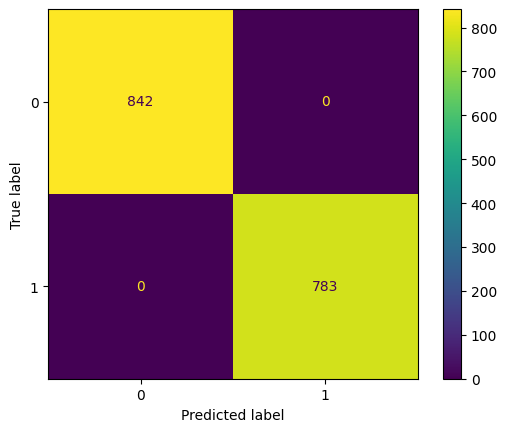

In [15]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:',precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Adjust the model to reduce the false negative
Given the problem under study, the false negative are dangerous, so the models is retrained to adjust it weight for each class

In [17]:
lr_adj = LogisticRegression(class_weight={0:1, 1:50})
lr_adj.fit(X_train, y_train)
y_pred_adj = lr_adj.predict(X_test)
print('Recall:', recall_score(y_test, y_pred_adj))

Recall: 1.0


## result
Reassess the result with the new model

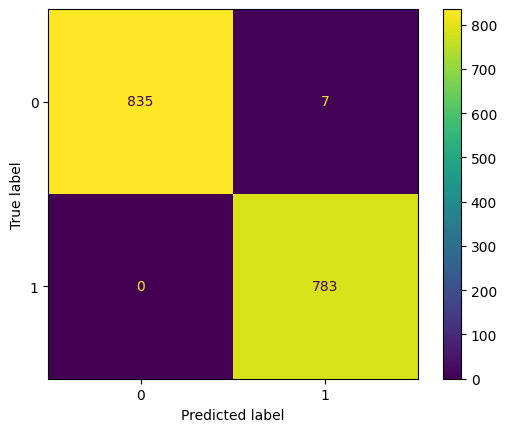

In [18]:
cm = confusion_matrix(y_test, y_pred_adj)
ConfusionMatrixDisplay(cm).plot()

In [19]:
y_prob = lr_adj.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
auc = roc_auc_score(y_test, y_prob)

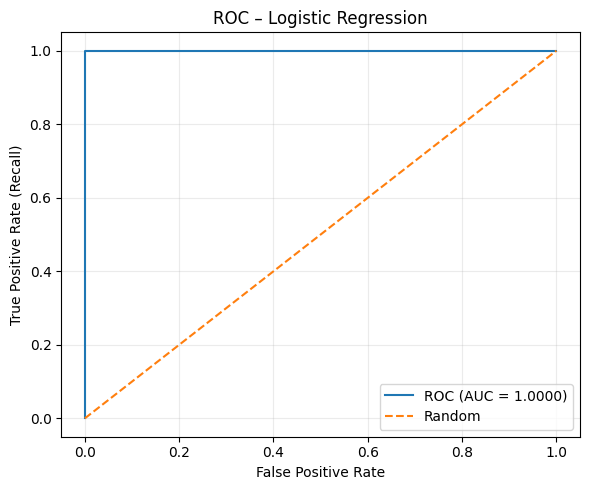

In [20]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0,1], [0,1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC – Logistic Regression")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## interpretation
Understanding the impact of the parameters. Uses the permutated coefficients to show the chart.

In [21]:
coefs = pd.DataFrame({
    "feature": X.columns,
    "coef": lr_adj.coef_[0],
    "odds_ratio": np.exp(lr_adj.coef_[0])
}).sort_values(by="odds_ratio", ascending=False)

print(coefs.head(10))


                       feature      coef  odds_ratio
28                 gill-size_n  6.139041  463.608739
80         spore-print-color_r  5.588225  267.260877
19                      odor_f  4.964903  143.294615
41                stalk-root_b  4.245365   69.781200
23                      odor_p  4.048498   57.311304
18                      odor_c  3.420365   30.580566
45  stalk-surface-above-ring_k  3.266160   26.210490
84                population_c  2.699453   14.871587
73                 ring-type_l  2.267990    9.659965
76         spore-print-color_h  2.082947    8.028093


In [22]:
r = permutation_importance(lr_adj, X, y, n_repeats=10, random_state=42)
imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": r.importances_mean.round(3),
    "std": r.importances_std.round(5)
}).sort_values(by="importance", ascending=False)

print(imp_df.head(10))

                       feature  importance      std
22                      odor_n       0.057  0.00167
28                 gill-size_n       0.030  0.00076
19                      odor_f       0.020  0.00160
41                stalk-root_b       0.018  0.00093
27              gill-spacing_w       0.016  0.00056
45  stalk-surface-above-ring_k       0.010  0.00076
78         spore-print-color_n       0.005  0.00053
48  stalk-surface-below-ring_k       0.004  0.00041
73                 ring-type_l       0.003  0.00056
80         spore-print-color_r       0.003  0.00019


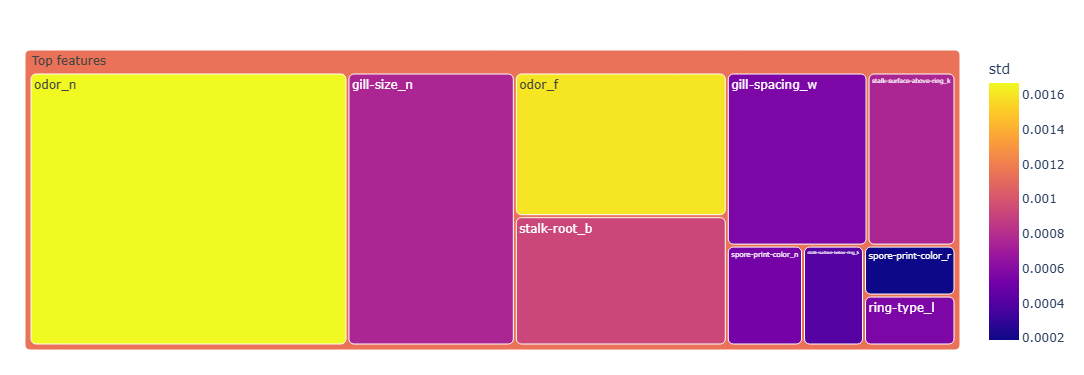

In [23]:
top = imp_df.head(10).iloc[::-1]
top.reset_index(drop=True, inplace=True)
fig = px.treemap(top, path=[px.Constant("Top features"), "feature"], values="importance", color="std")
fig.update_traces(root_color="lightgrey", marker=dict(cornerradius=5))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()